# Basic Walk-Through: k-nearest Neighbors

This notebook contains several examples that illustrate the machine learning workflow using a dataset of house prices.

We will use the fairly straightforward [k-nearest neighbors](https://scikit-learn.org/stable/modules/neighbors.html) (KNN) algorithm that allows us to tackle both regression and classification problems.

In its default sklearn implementation, it identifies the k nearest data points (based on the Euclidean distance) to make a prediction. It predicts the most frequent class among the neighbors or the average outcome in the classification or regression case, respectively.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.neighbors import (KNeighborsClassifier, KNeighborsRegressor)
from sklearn.model_selection import (cross_val_score, cross_val_predict, GridSearchCV)
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from yellowbrick.model_selection import ValidationCurve, LearningCurve

In [3]:
sns.set_style('whitegrid')

## Get the Data

### Kings County Housing Data

In [4]:
house_sales = pd.read_csv('kc_house_data.csv')

In [5]:
house_sales

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [6]:
house_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [7]:
house_sales = house_sales.drop(['id', 'zipcode', 'lat', 'long', 'date'], axis = 1)
house_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  sqft_living15  21613 non-null  int64  
 15  sqft_lot15     21613 non-null  int64  
dtypes: float64(3), int64(13)
memory usage: 2.6 MB


## Select & Transform Features

### Asset Prices often have long tails

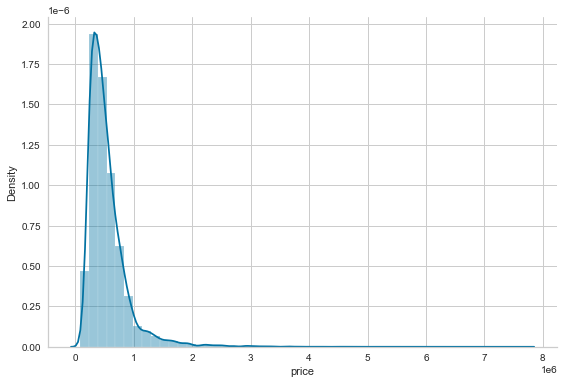

In [8]:
sns.distplot(house_sales['price'])
sns.despine()
plt.tight_layout();

### Use log-transform

Useful for dealing with [skewed data](http://onlinestatbook.com/2/transformations/log.html).

In [9]:
X_all = house_sales.drop('price', axis = 1)
y = np.log(house_sales['price'])

### Mutual information regression

See sklearn [docs](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection).

In [10]:
mi_reg = pd.Series(mutual_info_regression(X_all, y), 
                   index = X_all.columns).sort_values(ascending = False)

In [11]:
mi_reg

sqft_living      0.347236
grade            0.341837
sqft_living15    0.273292
sqft_above       0.258363
bathrooms        0.205314
sqft_lot15       0.084391
floors           0.081398
yr_built         0.077934
bedrooms         0.077647
sqft_basement    0.068262
sqft_lot         0.061918
view             0.058523
waterfront       0.014791
yr_renovated     0.008366
condition        0.005957
dtype: float64

In [12]:
X_all

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,1340,5650
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,1690,7639
2,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,2720,8062
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,1360,5000
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,1530,1509
21609,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,1830,7200
21610,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,1020,2007
21611,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,1410,1287


In [13]:
# Selects the top 10 features with the highest mutual information regression coefficients
X = X_all.loc[:, mi_reg.iloc[:10].index]

In [14]:
X

,sqft_living,grade,sqft_living15,sqft_above,bathrooms,sqft_lot15,floors,yr_built,bedrooms,sqft_basement
0,1180,7,1340,1180,1.00,5650,1.0,1955,3,0
1,2570,7,1690,2170,2.25,7639,2.0,1951,3,400
2,770,6,2720,770,1.00,8062,1.0,1933,2,0
3,1960,7,1360,1050,3.00,5000,1.0,1965,4,910
4,1680,8,1800,1680,2.00,7503,1.0,1987,3,0
...,...,...,...,...,...,...,...,...,...,...
21608,1530,8,1530,1530,2.50,1509,3.0,2009,3,0
21609,2310,8,1830,2310,2.50,7200,2.0,2014,4,0
21610,1020,7,1020,1020,0.75,2007,2.0,2009,2,0
21611,1600,8,1410,1600,2.50,1287,2.0,2004,3,0


### Bivariate Scatter Plots

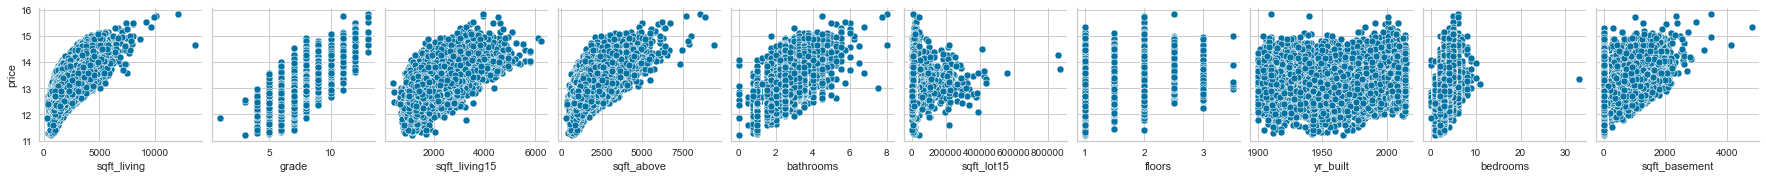

In [15]:
g = sns.pairplot(X.assign(price = y), y_vars = ['price'], x_vars = X.columns)
sns.despine();

### Explore Correlations

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sqft_living    21613 non-null  int64  
 1   grade          21613 non-null  int64  
 2   sqft_living15  21613 non-null  int64  
 3   sqft_above     21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_lot15     21613 non-null  int64  
 6   floors         21613 non-null  float64
 7   yr_built       21613 non-null  int64  
 8   bedrooms       21613 non-null  int64  
 9   sqft_basement  21613 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.6 MB


In [17]:
spearmanr(X['sqft_living'], y)

SpearmanrResult(correlation=0.6441909821578404, pvalue=0.0)

In [18]:
spearmanr(X['grade'], y)

SpearmanrResult(correlation=0.6582152214259374, pvalue=0.0)

In [19]:
spearmanr(X['sqft_living15'], y)

SpearmanrResult(correlation=0.5722897679433038, pvalue=0.0)

In [20]:
X.apply(lambda x: spearmanr(x, y)[0])

sqft_living      0.644191
grade            0.658215
sqft_living15    0.572290
sqft_above       0.541752
bathrooms        0.497160
sqft_lot15       0.062766
floors           0.322347
yr_built         0.102038
bedrooms         0.344652
sqft_basement    0.251704
dtype: float64

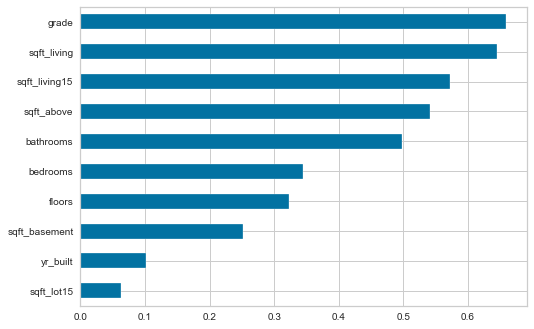

In [21]:
correl = X.apply(lambda x: spearmanr(x, y)[0])
correl.sort_values().plot.barh();

## KNN Regression

### In-sample performance with default settings

KNN uses distance to make predictions; it requires standardization of variables to avoid undue influence based on scale

In [22]:
X_scaled = scale(X)

In [23]:
model = KNeighborsRegressor()
model.fit(X = X_scaled, y = y)

KNeighborsRegressor()

In [24]:
y_pred = model.predict(X_scaled)

### Regression Error Metrics

In [25]:
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             mean_squared_log_error,
                             median_absolute_error,
                             r2_score)

#### Computing the prediction error

The error is the deviation from the true value, whereas a residual is the deviation from an estimated value, e.g., an estimate of the population mean.

In [26]:
error = (y - y_pred).rename('Prediction Errors')

In [27]:
error

0       -0.318307
1        0.011363
2       -0.392852
3        0.484024
4        0.428821
           ...   
21608   -0.163507
21609    0.016639
21610    0.102537
21611    0.023962
21612   -0.110341
Name: Prediction Errors, Length: 21613, dtype: float64

In [28]:
scores = dict(
    rmse = np.sqrt(mean_squared_error(y_true = y, y_pred = y_pred)),
    rmsle = np.sqrt(mean_squared_log_error(y_true = y, y_pred = y_pred)),
    mean_ae = mean_absolute_error(y_true = y, y_pred = y_pred),
    median_ae = median_absolute_error(y_true = y, y_pred = y_pred),
    r2score = r2_score(y_true = y, y_pred = y_pred)
)

In [29]:
scores

{'rmse': 0.25542884631173557,
 'rmsle': 0.018242696430479703,
 'mean_ae': 0.19704303362079598,
 'median_ae': 0.1578709733170971,
 'r2score': 0.7647883265439553}

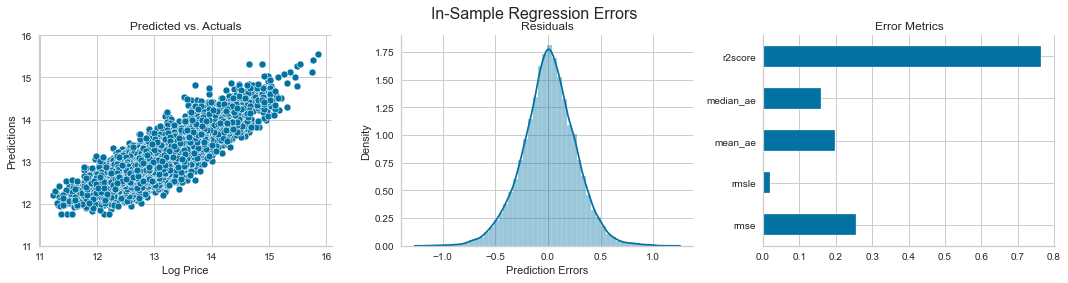

In [30]:
fig, axes = plt.subplots(ncols = 3, figsize = (15, 4))
sns.scatterplot(x = y, y = y_pred, ax = axes[0])
axes[0].set_xlabel('Log Price')
axes[0].set_ylabel('Predictions')
axes[0].set_ylim(11, 16)
axes[0].set_title('Predicted vs. Actuals')
sns.distplot(error, ax = axes[1])
axes[1].set_title('Residuals')
pd.Series(scores).plot.barh(ax = axes[2], title = 'Error Metrics')
fig.suptitle('In-Sample Regression Errors', fontsize = 16)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top = .88)

### Cross-Validation

Manual hyperparameter tuning; using [Pipeline](https://scikit-learn.org/stable/modules/compose.html#pipeline-chaining-estimators) ensures proper scaling for each fold using train metrics to standardize test data.

In [31]:
def rmse(y_true, pred):
    return np.sqrt(mean_squared_error(y_true = y_true, y_pred = pred))

rmse_score = make_scorer(rmse)

In [32]:
# Cross validate with these list of n_neighbors
[1] + list(range(5, 51, 5))

[1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

In [33]:
cv_rmse = {}

n_neighbors = [1] + list(range(5, 51, 5))

for n in n_neighbors:
    pipe = Pipeline([('scaler', StandardScaler()),
                     ('knn', KNeighborsRegressor(n_neighbors = n))])
    cv_rmse[n] = cross_val_score(pipe,
                                 X = X,
                                 y = y,
                                 scoring = rmse_score,
                                 cv = 5)

In [34]:
cv_rmse

{1: array([0.39805342, 0.4045388 , 0.40528479, 0.40955532, 0.38332445]),
 5: array([0.32354157, 0.32422928, 0.3145421 , 0.3255736 , 0.30376237]),
 10: array([0.31521152, 0.31350205, 0.30459462, 0.31739395, 0.29390868]),
 15: array([0.31228123, 0.31119856, 0.3021452 , 0.31514321, 0.29103432]),
 20: array([0.3129104 , 0.31005535, 0.30020819, 0.31317065, 0.28900972]),
 25: array([0.31310433, 0.30960907, 0.30007457, 0.31315454, 0.28834439]),
 30: array([0.31329854, 0.30972437, 0.30016749, 0.31239453, 0.28842607]),
 35: array([0.31353389, 0.30936622, 0.3002203 , 0.31273323, 0.28872763]),
 40: array([0.3137502 , 0.30965647, 0.30116049, 0.3134294 , 0.28926536]),
 45: array([0.31423535, 0.31013521, 0.30172779, 0.3136832 , 0.2900428 ]),
 50: array([0.31425459, 0.31035748, 0.30222297, 0.31384411, 0.29070415])}

In [35]:
cv_rmse = pd.DataFrame.from_dict(cv_rmse, orient = 'index')

In [36]:
cv_rmse

,0,1,2,3,4
1,0.398053,0.404539,0.405285,0.409555,0.383324
5,0.323542,0.324229,0.314542,0.325574,0.303762
10,0.315212,0.313502,0.304595,0.317394,0.293909
15,0.312281,0.311199,0.302145,0.315143,0.291034
20,0.312910,0.310055,0.300208,0.313171,0.289010
25,0.313104,0.309609,0.300075,0.313155,0.288344
30,0.313299,0.309724,0.300167,0.312395,0.288426
35,0.313534,0.309366,0.300220,0.312733,0.288728
40,0.313750,0.309656,0.301160,0.313429,0.289265
45,0.314235,0.310135,0.301728,0.313683,0.290043


In [37]:
best_n, best_rmse = cv_rmse.mean(axis = 1).idxmin(), cv_rmse.mean(axis = 1).min()
cv_rmse = cv_rmse.stack().reset_index()
cv_rmse.columns = ['n', 'fold', 'RMSE']
cv_rmse

,n,fold,RMSE
0,1,0,0.398053
1,1,1,0.404539
2,1,2,0.405285
3,1,3,0.409555
4,1,4,0.383324
5,5,0,0.323542
6,5,1,0.324229
7,5,2,0.314542
8,5,3,0.325574
9,5,4,0.303762


In [38]:
best_n, best_rmse

(30, 0.3048022034877519)

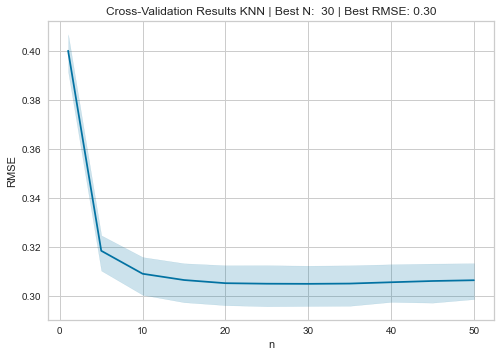

In [39]:
ax = sns.lineplot(x = 'n', y = 'RMSE', data = cv_rmse)
ax.set_title(f'Cross-Validation Results KNN | Best N: {best_n : d} | Best RMSE: {best_rmse:.2f}');

#### Actuals vs Predicted

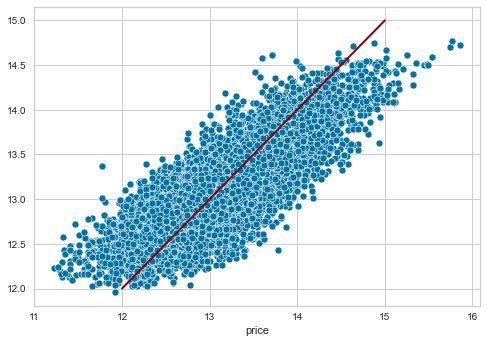

In [40]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('knn', KNeighborsRegressor(n_neighbors = best_n))
                 ])
y_pred = cross_val_predict(pipe, X, y, cv = 5)

ax = sns.scatterplot(x = y, y = y_pred)
y_range = list(range(int(y.min() + 1), int(y.max() + 1)))

pd.Series(y_range, index = y_range).plot(ax = ax, lw = 2, c = 'darkred');

#### Cross-Validation Errors

In [41]:
error = (y - y_pred).rename('Prediction Errors')

In [42]:
error

0       -0.408473
1        0.064345
2       -0.571139
3        0.411227
4        0.447938
           ...   
21608   -0.229531
21609    0.011111
21610    0.336977
21611   -0.024038
21612    0.139283
Name: Prediction Errors, Length: 21613, dtype: float64

In [43]:
scores = dict(
    rmse = np.sqrt(mean_squared_error(y_true = y, y_pred = y_pred)),
    rmsle = np.sqrt(mean_squared_log_error(y_true = y, y_pred = y_pred)),
    mean_ae = mean_absolute_error(y_true = y, y_pred = y_pred),
    median_ae = median_absolute_error(y_true = y, y_pred = y_pred),
    r2score = r2_score(y_true = y, y_pred = y_pred)
)

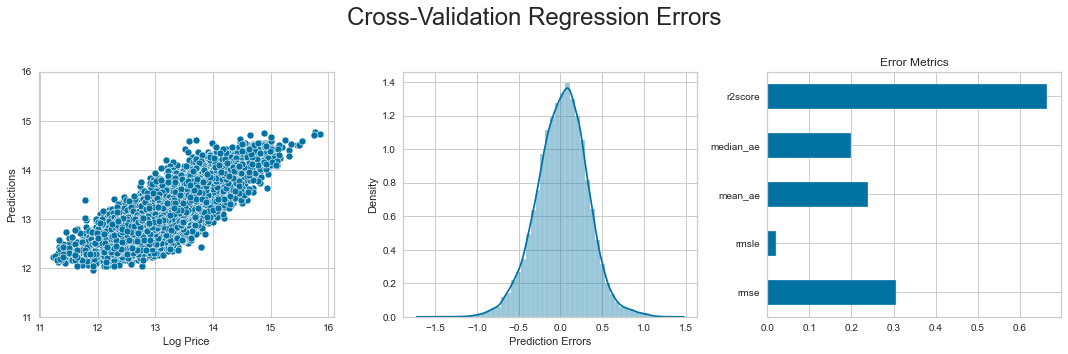

In [44]:
fig, axes = plt.subplots(ncols = 3, figsize = (15, 5))
sns.scatterplot(x = y, y = y_pred, ax = axes[0])
axes[0].set_xlabel('Log Price')
axes[0].set_ylabel('Predictions')
axes[0].set_ylim(11, 16)
sns.distplot(error, ax = axes[1])
pd.Series(scores).plot.barh(ax = axes[2], title = 'Error Metrics')
fig.suptitle('Cross-Validation Regression Errors', fontsize = 24)
fig.tight_layout()
plt.subplots_adjust(top = 0.8);

### GridSearchCV with Pipeline

See sklearn [docs](https://scikit-learn.org/stable/modules/grid_search.html#tuning-the-hyper-parameters-of-an-estimator).


In [45]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('knn', KNeighborsRegressor())])

n_folds = 5

n_neighbors = tuple(range(5, 101, 5))

param_grid = {'knn__n_neighbors' : n_neighbors}

estimator = GridSearchCV(estimator = pipe,
                         param_grid = param_grid,
                         cv = n_folds,
                         scoring = rmse_score,
                         n_jobs = -1)

estimator.fit(X = X, y = y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': (5, 10, 15, 20, 25, 30, 35, 40, 45,
                                              50, 55, 60, 65, 70, 75, 80, 85,
                                              90, 95, 100)},
             scoring=make_scorer(rmse))

In [46]:
cv_results = estimator.cv_results_

In [47]:
cv_results

{'mean_fit_time': array([0.04500208, 0.03031483, 0.02940216, 0.02925959, 0.05498667,
        0.04988117, 0.03411431, 0.0284204 , 0.02651029, 0.02637243,
        0.02793379, 0.03067584, 0.03366899, 0.02587018, 0.02636213,
        0.02963958, 0.02824984, 0.02809176, 0.0280549 , 0.0359118 ]),
 'std_fit_time': array([0.0217675 , 0.00296022, 0.00418858, 0.00208574, 0.02381772,
        0.0175892 , 0.00969408, 0.00209382, 0.00166278, 0.0031592 ,
        0.00067494, 0.005656  , 0.01472261, 0.00096762, 0.0011991 ,
        0.00366697, 0.00191306, 0.00296322, 0.0043237 , 0.00867638]),
 'mean_score_time': array([0.57183661, 0.65193343, 0.74831762, 0.95706444, 1.9482265 ,
        1.43870997, 1.27725801, 1.11851668, 1.09986119, 1.13453727,
        1.26290183, 1.22462883, 1.18389921, 1.18311934, 1.27443137,
        1.56428757, 1.50901475, 1.40836015, 1.40376387, 3.73323503]),
 'std_score_time': array([0.03599195, 0.0341805 , 0.03182375, 0.14217002, 0.12033862,
        0.23333638, 0.07819258, 0.067385

In [48]:
test_scores = pd.DataFrame({fold : cv_results[f'split{fold}_test_score'] for fold in range(n_folds)},
                           index = n_neighbors).stack().reset_index()

test_scores.columns = ['k', 'fold', 'RMSE']

In [49]:
test_scores

,k,fold,RMSE
0,5,0,0.323542
1,5,1,0.324229
2,5,2,0.314542
3,5,3,0.325574
4,5,4,0.303762
...,...,...,...
95,100,0,0.317465
96,100,1,0.315336
97,100,2,0.306831
98,100,3,0.318158


In [50]:
mean_rmse = test_scores.groupby('k')['RMSE'].mean()
best_k, best_score = mean_rmse.idxmin(), mean_rmse.min()

In [51]:
best_k, best_score

(30, 0.3048022034877519)

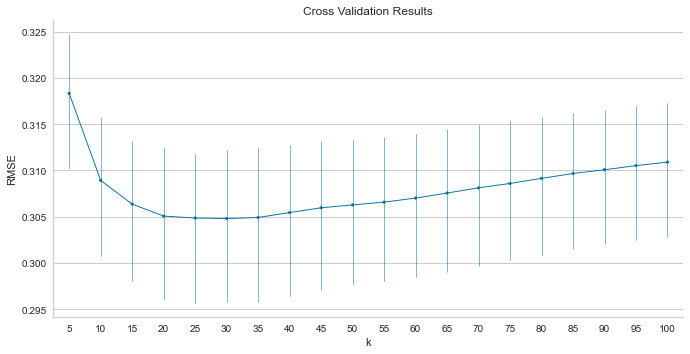

In [52]:
sns.pointplot(x = 'k', y = 'RMSE', data = test_scores, scale = 0.3, joiin = False, errwidth = 0.5)
plt.title('Cross Validation Results')
sns.despine()
plt.tight_layout()
plt.gcf().set_size_inches(10, 5);

### The bias-variance trade-off

The prediction errors of an ML model can be broken down into reducible and irreducible parts. The irreducible part is due to random variation (noise) in the data due to, for example, the absence of relevant variables, natural variation, or measurement errors. The reducible part of the generalization error, in turn, can be broken down into errors due to bias and variance.
Both result from discrepancies between the true functional relationship and the assumptions made by the machine learning algorithm, as detailed in the following list:

- __Error due to bias__: The hypothesis is too simple to capture the complexity of the true functional relationship. As a result, whenever the model attempts to learn the true function, it makes systematic mistakes and, on average, the predictions will be similarly biased. This is also called __underfitting__. 
<br /><br />

- __Error due to variance__: The algorithm is overly complex in view of the true relationship. Instead of capturing the true relationship, it __overfits__ the data
and extracts patterns from the noise. As a result, it learns different functional relationships from each sample, and out-of-sample predictions will vary widely.

![overfitting](/Users/marioht/Dropbox/EDHEC/2022/COURSES/S2/Prediction_&_Sequential_Investment_Strategies/Presentations/2nd_FINAL/overfitting_with_polynomials.png)

### Train & Validation Curves with yellowbricks

Validation curves (see the first figure below) visualize the impact of a single hyperparameter on a model's cross-validation performance. This is useful to determine whether the model underfits or overfits the given dataset.
In our example of KNeighborsRegressor, which only has a single hyperparameter, the number of neighbors is _k_. Note that model complexity increases as the number of neighbors drop because the model can now make predictions for more distinct areas in the feature space.
We can see that the model __underfits for values of k above 20__. The validation error drops as we reduce the number of neighbors and make our model more complex. For __values below 20__, the model begins to __overfit__ as training and validation errors diverge and average out-of-sample performance quickly deteriorates:

See background on [learning curves](https://en.wikipedia.org/wiki/Learning_curve) and yellowbrick [docs](https://www.scikit-yb.org/en/latest/).

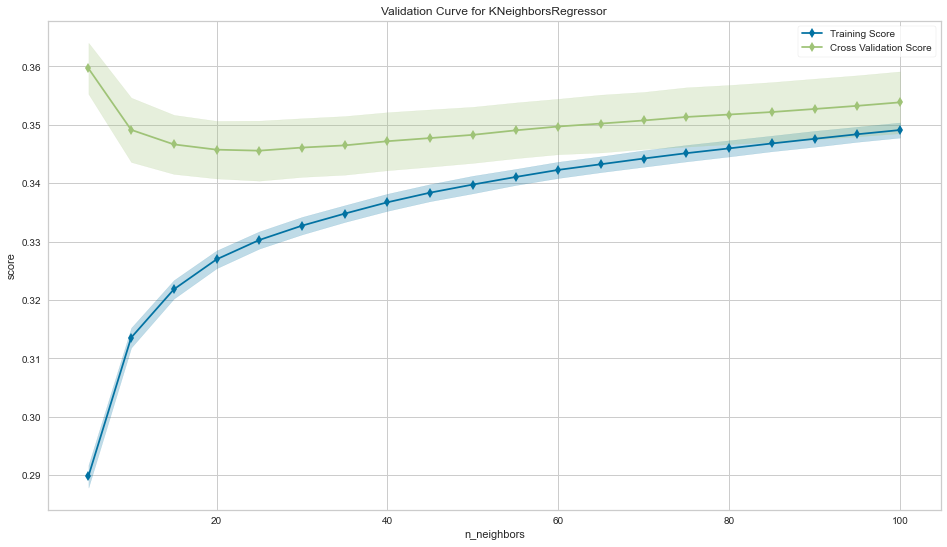

<Figure size 576x396 with 0 Axes>

In [53]:
fig, ax = plt.subplots(figsize = (16, 9))

val_curve = ValidationCurve(KNeighborsRegressor(),
                            param_name = 'n_neighbors',
                            param_range = n_neighbors,
                            cv = 5,
                            scoring = rmse_score,
                            n_jobs = -1,
                            ax = ax)

val_curve.fit(X, y)
val_curve.show()
sns.despine()
fig.tight_layout();

### Learning curves – diagnosing the bias-variance trade-off
The learning curve (see the below figure) helps determine whether a model's cross-validation performance would benefit from additional data, and whether the prediction errors are more driven by bias or by variance.

More data is unlikely to improve performance if training and cross-validation scores converge. At this point, it is important to evaluate whether the model performance meets expectations, determined by a human benchmark. If this is not the case, then you should modify the model's hyperparameter settings to better capture the relationship between the features and the outcome, or choose a different algorithm with a higher capacity to capture complexity.

In addition, the variation of train and test errors shown by the shaded confidence intervals provides clues about the bias and variance sources of the prediction error. Variability around the cross-validation error is evidence of variance, whereas variability for the training set suggests bias, depending on the size of the training error.

In our example, the cross-validation performance has continued to drop, __but the incremental improvements have shrunk__, and the errors have plateaued, so there are unlikely to be many benefits from a larger training set. On the other hand, the data is showing __substantial variance__ given the range of validation errors compared to that shown for the training errors.

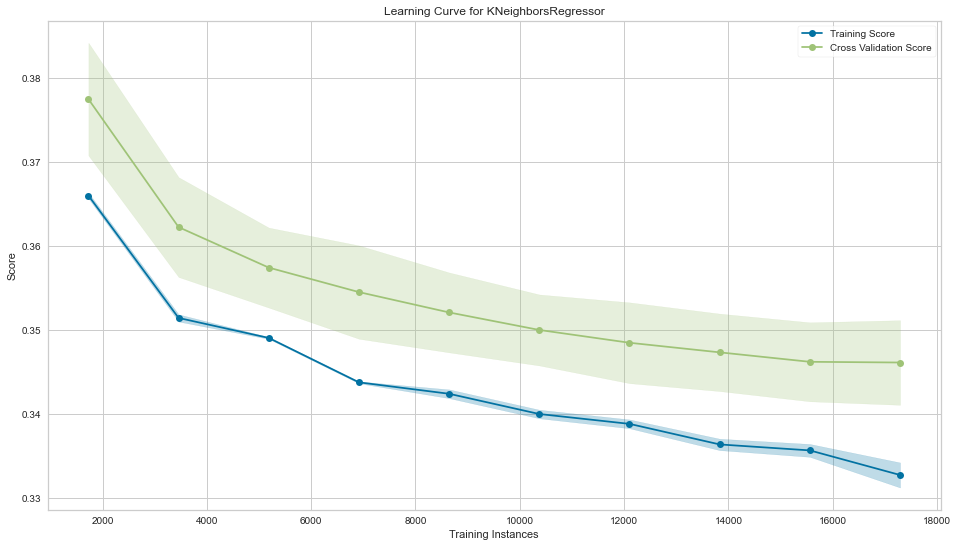

<Figure size 576x396 with 0 Axes>

In [54]:
fig, ax = plt.subplots(figsize = (16, 9))
l_curve = LearningCurve(KNeighborsRegressor(n_neighbors = best_k),
                        train_sizes = np.arange(0.1, 1.01, 0.1),
                        scoring = rmse_score,
                        cv = 5,
                        n_jobs = -1,
                        ax = ax)

l_curve.fit(X, y)
l_curve.show()
sns.despine( )
fig.tight_layout();

## Binary Classification

In [55]:
y

0        12.309982
1        13.195614
2        12.100712
3        13.311329
4        13.142166
           ...    
21608    12.793859
21609    12.899220
21610    12.904459
21611    12.899220
21612    12.691580
Name: price, Length: 21613, dtype: float64

In [56]:
y.median()

13.017002861746503

In [57]:
y_binary = (y > y.median()).astype(int)

In [58]:
y_binary

0        0
1        1
2        0
3        1
4        1
        ..
21608    0
21609    0
21610    0
21611    0
21612    0
Name: price, Length: 21613, dtype: int64

In [59]:
n_neighbors = tuple(range(5, 151, 10))
n_folds = 5
scoring = 'roc_auc'

In [60]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('knn', KNeighborsClassifier())])

param_grid = {'knn__n_neighbors' : n_neighbors}

estimator = GridSearchCV(estimator = pipe,
                         param_grid = param_grid,
                         cv = n_folds,
                         scoring = scoring,
                         n_jobs = -1)

estimator.fit(X = X, y = y_binary)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': (5, 15, 25, 35, 45, 55, 65, 75, 85,
                                              95, 105, 115, 125, 135, 145)},
             scoring='roc_auc')

In [61]:
best_k = estimator.best_params_['knn__n_neighbors']

In [62]:
best_k

65

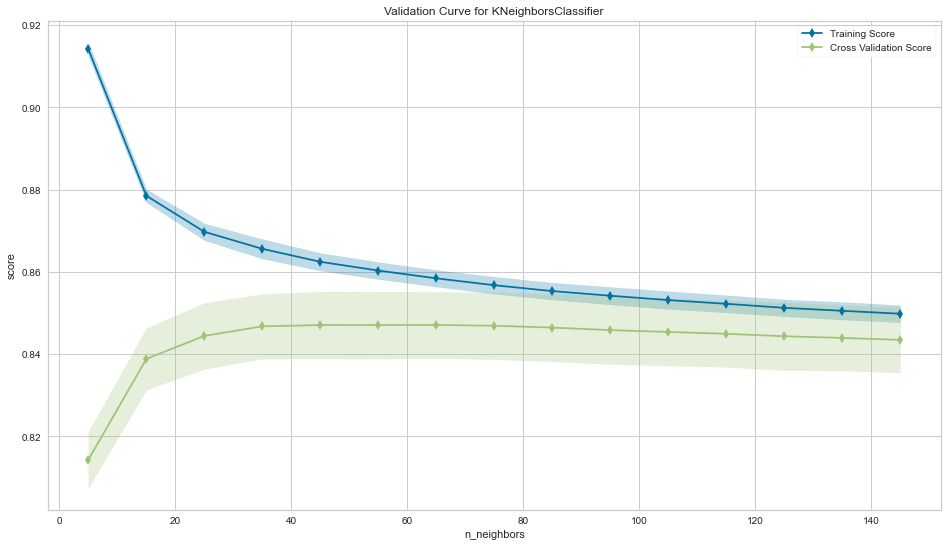

<Figure size 576x396 with 0 Axes>

In [63]:
fig, ax = plt.subplots(figsize = (16, 9))
val_curve = ValidationCurve(KNeighborsClassifier(),
                      param_name = 'n_neighbors',
                      param_range = n_neighbors,
                      cv = n_folds,
                      scoring = scoring,
                      n_jobs = -1,
                      ax = ax)
val_curve.fit(X, y_binary)
val_curve.show()
sns.despine()
fig.tight_layout();

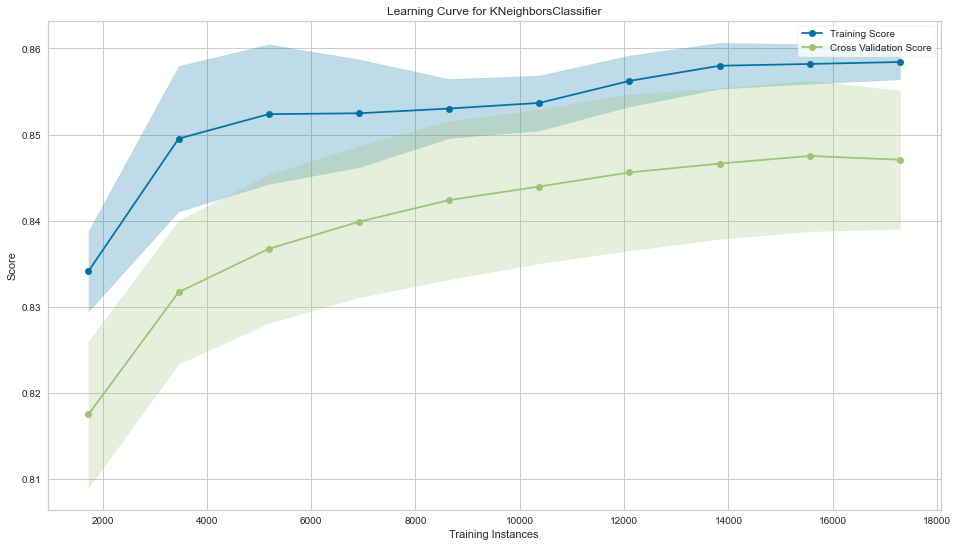

<Figure size 576x396 with 0 Axes>

In [64]:
fig, ax = plt.subplots(figsize = (16, 9))
l_curve = LearningCurve(KNeighborsClassifier(n_neighbors = best_k),
                        train_sizes = np.arange(0.1, 1.01, 0.1), 
                        scoring = scoring,
                        cv = 5,
                        n_jobs = -1,
                        ax = ax)
l_curve.fit(X, y_binary)
l_curve.show()
sns.despine()
fig.tight_layout();

## Binary Classification

In [65]:
from sklearn.metrics import (classification_report,
                             accuracy_score,
                             zero_one_loss,
                             roc_auc_score,
                             roc_curve,
                             brier_score_loss,
                             cohen_kappa_score,
                             confusion_matrix,
                             fbeta_score,
                             hamming_loss,
                             hinge_loss,
                             jaccard_score,
                             log_loss,
                             matthews_corrcoef,
                             f1_score,
                             average_precision_score,
                             precision_recall_curve)

|Name| API|
|:----|----|
|Area Under the Receiver Operating Characteristic Curve (ROC AUC) | roc_auc_score(y_true, y_score[, …])|
|Receiver operating characteristic (ROC) | roc_curve(y_true, y_score[, …])|
|Average precision (AP) | average_precision_score(y_true, y_score)|
|Precision-recall pairs | precision_recall_curve(y_true, …)|
|Precision, recall, F-measure and support | precision_recall_fscore_support(…)|
|F1 Score | f1_score(y_true, y_pred[, labels, …])|
|F-beta Score | fbeta_score(y_true, y_pred, beta[, …])|
|Precision | precision_score(y_true, y_pred[, …]|
|Recall | recall_score(y_true, y_pred[, …])|
|Main classification metrics | classification_report(y_true, y_pred)|
|confusion matrix | confusion_matrix(y_true, y_pred[, …])|
|Accuracy classification score | accuracy_score(y_true, y_pred)|
|Zero-one classification loss | zero_one_loss(y_true, y_pred[, …])|
|Average Hamming loss | hamming_loss(y_true, y_pred[, …])|
|Brier score | brier_score_loss(y_true, y_prob[, …])|
|Cohen’s kappa | cohen_kappa_score(y1, y2[, labels, …])|
|Average hinge loss | hinge_loss(y_true, pred_decision[, …])|
|Jaccard similarity coefficient | jaccard_similarity_score(y_true, y_pred)|
|Log loss, aka logistic loss or cross-entropy loss | log_loss(y_true, y_pred[, eps, …])|
|Matthews correlation coefficient (MCC) | matthews_corrcoef(y_true, y_pred[, …])|

In [66]:
y_score = cross_val_predict(KNeighborsClassifier(best_k),
                            X = X,
                            y = y_binary,
                            cv = 5,
                            n_jobs = -1,
                            method = 'predict_proba')[:, 1]

In [67]:
y_score

array([0.24615385, 0.58461538, 0.26153846, ..., 0.18461538, 0.41538462,
       0.24615385])

#### Using Predicted Probabilities

In [68]:
pred_scores = dict(y_true = y_binary, y_score = y_score)

##### ROC AUC

In [69]:
roc_auc_score(**pred_scores)

0.8460169463310011

In [70]:
cols = ['False Positive Rate', 'True Positive Rate', 'threshold']
roc = pd.DataFrame(dict(zip(cols, roc_curve(**pred_scores))))

In [71]:
roc

,False Positive Rate,True Positive Rate,threshold
0,0.000000,0.000000,2.000000
1,0.000368,0.037678,1.000000
2,0.000736,0.074519,0.984615
3,0.001197,0.107266,0.969231
4,0.002485,0.139641,0.953846
...,...,...,...
62,0.884665,0.996186,0.061538
63,0.917618,0.997767,0.046154
64,0.948730,0.998698,0.030769
65,0.978829,0.999442,0.015385


##### Precision-Recall

In [72]:
precision, recall, ts = precision_recall_curve(y_true = y_binary, probas_pred = y_score)
pr_curve = pd.DataFrame({'Precision' : precision, 'Recall' : recall})

In [73]:
pr_curve

,Precision,Recall
0,0.497340,1.000000
1,0.502549,0.999442
2,0.510170,0.998698
3,0.518266,0.997767
4,0.526994,0.996186
...,...,...
62,0.982330,0.139641
63,0.988851,0.107266
64,0.990111,0.074519
65,0.990220,0.037678


##### F1 Score - Optimize Threshold

In [74]:
f1 = pd.Series({t : f1_score(y_true = y_binary, y_pred = y_score > t) for t in ts})
best_threshold = f1.idxmax()

##### Plot

In [75]:
roc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   False Positive Rate  67 non-null     float64
 1   True Positive Rate   67 non-null     float64
 2   threshold            67 non-null     float64
dtypes: float64(3)
memory usage: 1.7 KB


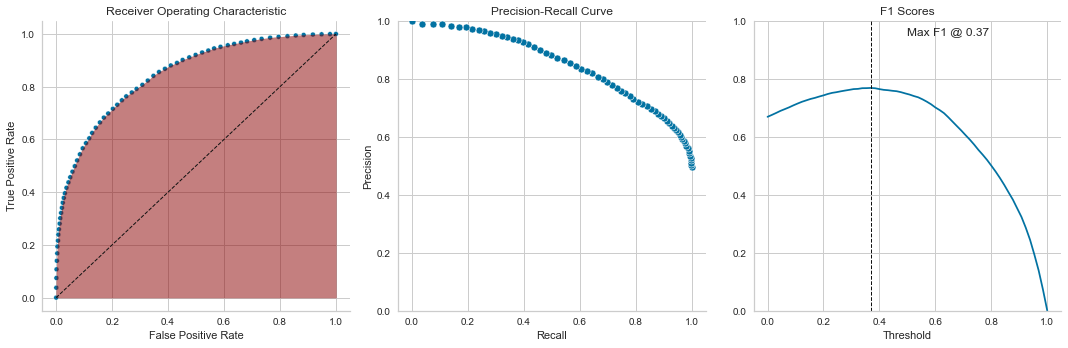

In [76]:
fig, axes = plt.subplots(ncols = 3, figsize = (15, 5))

ax = sns.scatterplot(x = 'False Positive Rate', y = 'True Positive Rate', data = roc, size = 5, legend = False, ax = axes[0])
axes[0].plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color = 'k', ls = '--', lw = 1)
axes[0].fill_between(y1 = roc['True Positive Rate'], x = roc['False Positive Rate'], alpha = .5,color = 'darkred')
axes[0].set_title('Receiver Operating Characteristic')


sns.scatterplot(x = 'Recall', y = 'Precision', data = pr_curve, ax = axes[1])
axes[1].set_ylim(0,1)
axes[1].set_title('Precision-Recall Curve')


f1.plot(ax = axes[2], title = 'F1 Scores', ylim = (0,1))
axes[2].set_xlabel('Threshold')
axes[2].axvline(best_threshold, lw = 1, ls = '--', color = 'k')
axes[2].text(s = f'Max F1 @ {best_threshold:.2f}', x = .5, y = .95)
sns.despine()
fig.tight_layout();

##### Average Precision

In [77]:
average_precision_score(y_true = y_binary, y_score = y_score)

0.8484132538564065

##### Brier Score

In [78]:
brier_score_loss(y_true = y_binary, y_prob = y_score)

0.16023119988326112

#### Use Predictions after thresholding

In [79]:
y_pred = y_score > best_threshold

In [80]:
scores = dict(y_true = y_binary, y_pred =y_pred)

##### F-beta Score

In [81]:
fbeta_score(**scores, beta = 1)

0.768421052631579

In [82]:
print(classification_report(**scores))

              precision    recall  f1-score   support

           0       0.82      0.63      0.71     10864
           1       0.70      0.86      0.77     10749

    accuracy                           0.74     21613
   macro avg       0.76      0.74      0.74     21613
weighted avg       0.76      0.74      0.74     21613



##### Confusion Matrix

In [83]:
confusion_matrix(**scores)

array([[6871, 3993],
       [1551, 9198]])

##### Accuracy

In [84]:
accuracy_score(**scores)

0.743487715726646

##### Zero-One Loss

In [85]:
zero_one_loss(**scores)

0.25651228427335404

##### Hamming Loss

Fraction of labels that are incorrectly predicted

In [86]:
hamming_loss(**scores)

0.256512284273354

##### Cohen's Kappa

Score that expresses the level of agreement between two annotators on a classification problem.

In [87]:
cohen_kappa_score(y1 = y_binary, y2 = y_pred)

0.4875770533373557

##### Hinge Loss


In [88]:
hinge_loss(y_true = y_binary, pred_decision = y_pred)

0.7591727201221488

##### Jaccard Similarity

In [89]:
jaccard_score(**scores)

0.6239316239316239

##### Log Loss / Cross Entropy Loss

In [90]:
log_loss(**scores)

8.859768154625623

##### Matthews Correlation Coefficient

In [91]:
matthews_corrcoef(**scores)

0.5004925066659417

`End of File`